In [ ]:
!pip install tensorflow matplotlib scikit-learn

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

**Data Preparation**

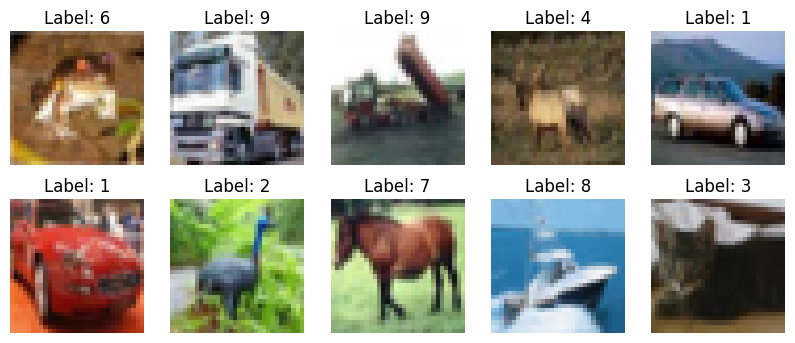

In [ ]:
# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalisasi pixel (0-255 menjadi 0-1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels ke one-hot encoding
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)


# Data Augmentation
data_augmentation = tf.keras.Sequential([   # Menambah variasi data latih secara artifisial
    # Transformasi yang digunakan ada 3
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Visualisasi Data
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i])
    plt.title(f"Label: {y_train[i][0]}")
    plt.axis('off')
plt.show()

**Model Architecture**

In [ ]:
# Menentukan bentuk input data
input_shape = x_train.shape[1:]   # Mengambil ukuran tanpa jumlah data

model = models.Sequential([   # Membuat Model Sequential dengan membangun layer demi layer secara berurutan
    layers.Input(shape=input_shape),
    data_augmentation,
    # Konvolusi menggunakan 32 layer
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    # Konvolusi menggunakan 64 layer
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    # Mengubah feature map 2D menjadi Vektor 1D
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,168,362 (8.27 MB)

 Trainable params: 2,168,362 (8.27 MB)

 Non-trainable params: 0 (0.00 B)

**Transfer Learning**

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
base_model.trainable = False  # freeze convolutional layers

model_tl = models.Sequential([
    layers.Resizing(224,224),  # ResNet50 expects 224x224
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model_tl.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

**Training Pipeline Setup**

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks: early stopping & save best model
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
]

**Training Model**

In [ ]:
history = model.fit(
    x_train, y_train_cat,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.2838 - loss: 1.9246

625/625 ━━━━━━━━━━━━━━━━━━━━ 254s 398ms/step - accuracy: 0.2839 - loss: 1.9243 - val_accuracy: 0.4802 - val_loss: 1.4418
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.4622 - loss: 1.4735

625/625 ━━━━━━━━━━━━━━━━━━━━ 237s 379ms/step - accuracy: 0.4622 - loss: 1.4734 - val_accuracy: 0.5647 - val_loss: 1.2283
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.5253 - loss: 1.3213

625/625 ━━━━━━━━━━━━━━━━━━━━ 252s 403ms/step - accuracy: 0.5253 - loss: 1.3213 - val_accuracy: 0.5925 - val_loss: 1.1342
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.5588 - loss: 1.2262

625/625 ━━━━━━━━━━━━━━━━━━━━ 237s 380ms/step - accuracy: 0.5588 - loss: 1.2262 - val_accuracy: 0.6277 - val_loss: 1.0666
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 241s 386ms/step - accuracy: 0.5845 - loss: 1.1725 - val_accuracy: 0.5869 - val_loss: 1.2135
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6058 - loss: 1.1159

625/625 ━━━━━━━━━━━━━━━━━━━━ 250s 401ms/step - accuracy: 0.6057 - loss: 1.1159 - val_accuracy: 0.6636 - val_loss: 0.9641
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 232s 371ms/step - accuracy: 0.6067 - loss: 1.0984 - val_accuracy: 0.6545 - val_loss: 1.0041
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 273s 388ms/step - accuracy: 0.6229 - loss: 1.0586 - val_accuracy: 0.6677 - val_loss: 0.9770
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.6335 - loss: 1.0367

625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 382ms/step - accuracy: 0.6335 - loss: 1.0367 - val_accuracy: 0.6713 - val_loss: 0.9397
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.6447 - loss: 1.0144

625/625 ━━━━━━━━━━━━━━━━━━━━ 247s 395ms/step - accuracy: 0.6447 - loss: 1.0144 - val_accuracy: 0.6759 - val_loss: 0.9381


313/313 - 13s - 42ms/step - accuracy: 0.6737 - loss: 0.9461
Test Accuracy: 67.37%
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step
Confusion Matrix:
 [[721  50  23   8   5   4  11  24  55  99]
 [  6 854   0   0   1   1  10   1   4 123]
 [115  20 422  38  83  49 155  67  16  35]
 [ 34  30  30 404  57 147 146  67  24  61]
 [ 35   6  30  29 508  26 212 134   5  15]
 [ 16  10  32 127  53 520  74 119  12  37]
 [  8   5  13  42  15  11 857   8   4  37]
 [ 11   4  15  19  36  30  23 819   0  43]
 [ 71  66   8  11   3   3   8   8 748  74]
 [ 25  63   2   5   1   2   3  10   5 884]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.72      0.71      1000
           1       0.77      0.85      0.81      1000
           2       0.73      0.42      0.54      1000
           3       0.59      0.40      0.48      1000
           4       0.67      0.51      0.58      1000
           5       0.66      0.52      0.58      1000
           6       0.5

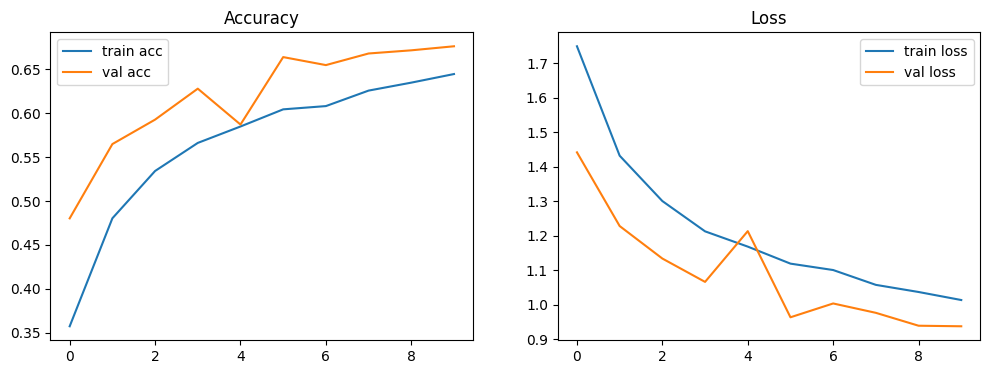

In [ ]:
# Load best model
model.load_weights("best_model.h5")

# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=2)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Predict
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Classification report
cr = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", cr)

# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()